In [1]:
# Reference for the code: Xiaoming Ye and Siamese with MNIST from the sourse below:
# https://keras.io/examples/mnist_siamese/

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
#%tensorflow_version 1.x
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Subtract
from keras.optimizers import RMSprop
from keras import backend as K

from numpy.random import permutation
import itertools
from keras.models import load_model

import matplotlib.pyplot as plt
from itertools import  tee
from sklearn.cluster import KMeans


Using TensorFlow backend.


In [2]:
def euclidean_distance(vects):
    '''
     function for calculating euclidean distance between to feature vectors in a siamese network
    '''
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    
    shape1, shape2 = shapes
    return (shape1[0], 1)

def randExcept(bottom, top,c1):
    '''
    helper function for creating a negative pair 
    '''
    while True:
      y = random.randint(bottom, top)
      if(y != c1):
        return y
def generate_a_pair(x, digit_indices, c1, c2):
  
  '''Positive and negative pair creation.
  Alternates between positive and negative pairs.
  '''
  pairs = []
  digit1_len = len(digit_indices[c1])
  digit2_len = len(digit_indices[c2])
  #choose x1
  index1 = digit_indices[c1][random.randint(0, digit1_len-1)]
  index2 = digit_indices[c2][random.randint(0, digit2_len-1)]
  pairs += [[x[index1], x[index2]]]
  return pairs
def generate_pairs(x, digit_indices, c1,c2, num):
  
  pairs = []
  for i in range(num):
    pairs += generate_a_pair(x, digit_indices, c1, c2)
  return pairs


In [3]:
def listOneOrZero_siamese(prevLabels, c1,c2, numNewLabel):
  
  if(c1 == c2):
    prevLabels += [1] * numNewLabel
  else:
    prevLabels += [0] * numNewLabel
  return prevLabels
def appendLabel_siamese(prevLabels, c1,c2):
  
  if(c1 == c2):
    prevLabels.append(1)
  else:
    prevLabels.append(0)

def preparePairData(x, digit_indices, c1, c2):
  '''
  function for creating positive and 3 type of negative pairs
  '''
  pairs = []
  labels = []
  pairs += generate_pairs(x, digit_indices, c1, c2, num_c1c2_samples)
  labels = [1] * num_c1c2_samples
  for i in range(num_c1_samples):
    diffC2 = randExcept(0, n_classes-1, c2)
    pairs += generate_a_pair(x, digit_indices, c1, diffC2)
  labels += [0] * num_c1_samples
  for i in range(num_c2_samples):
    diffC1 = randExcept(0, n_classes-1, c1)
    pairs += generate_a_pair(x, digit_indices, diffC1, c2);
  labels += [0] * num_c2_samples
  for i in range(num_neg_samples):
    diffC1 = randExcept(0, n_classes-1, c1)
    diffC2 = randExcept(0, n_classes-1, c2)
    pairs += generate_a_pair(x, digit_indices, diffC1, diffC2);
  labels += [0] * num_neg_samples
  return pairs, labels

  ##version 2
def create_pairs(x,digit_indices,c1,c2):
  
  all_pairs = []
  all_labels = []
  pairs, labels = preparePairData(x, digit_indices, c1, c2)
  all_pairs += pairs
  all_labels += labels
  all_pairs = np.array(all_pairs)
  all_labels = np.array(all_labels)
  return all_pairs, all_labels
  
def create_pairs_of_only_2classes(x,digit_indices,c1,c2):
  
  pairs = []
  labels = []
  pairs += generate_pairs(x, digit_indices, c1, c2, num_c1c2_samples)
  labels = [1] * num_c1c2_samples
  
  pairs += generate_pairs(x, digit_indices, c1, c1, num_c1_samples)
  labels += [0] * num_c1_samples
  
  pairs += generate_pairs(x, digit_indices, c2, c2, num_c2_samples)
  labels += [0] * num_c2_samples
  
  pairs = np.array(pairs)
  labels = np.array(labels)
  return pairs, labels

In [4]:
def create_base_network(input_shape):
    
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)
    

### my version, loss and accuracy for C2C-SN
def contrastive_loss(y_true, y_pred):
  
  '''Contrastive loss from Hadsell-et-al.'06
  http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  '''
  margin = 1
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))

  return K.mean(y_true * margin_square + (1-y_true) * square_pred)

In [5]:
def compute_accuracy(y_true, y_pred):
  '''Compute classification accuracy with a fixed threshold on distances.
  '''
  pred = y_pred.ravel() > 0.5
  return np.mean(pred == y_true)


def recall_m(y_true, y_pred):
  y_pred = K.cast(y_pred > 0.5, y_true.dtype)
  true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = (K.round(K.clip(y_true, 0, 1)))
  recall = K.mean(K.equal(true_positives, possible_positives))
  return recall

def precision_m(y_true, y_pred):
  y_pred = K.cast(y_pred > 0.5, y_true.dtype)
  true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = (K.round(K.clip(y_pred, 0, 1)))
  precision = K.mean(K.equal(true_positives, predicted_positives))
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


def accuracy(y_true, y_pred):
  '''Compute classification accuracy with a fixed threshold on distances.
  '''
  return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))
 

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

n_classes = 10 #len(np.unique(y_train))
num_classes = 10
epochs = 10


# number of positive samples
num_c1c2_samples = 5000
# number of half positive samples
num_c1_samples = 1750 #3500
num_c2_samples = 1750 #3500

# number of negative samples
num_neg_samples = 1500 #3000


In [8]:


def C2C_SN(c1, c2):
  print('training model '+ str(c1)+'_'+ str(c2) )

  # create training+test positive and negative pairs
  digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
  tr_pairs, tr_y = create_pairs(x_train, digit_indices,c1,c2)
  digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
  te_pairs, te_y = create_pairs(x_test, digit_indices,c1,c2)

  # network definition
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)#, name="side")

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  #c2c lower model
  subtracted = Subtract()([processed_a, processed_b])
  x = Dense(128, activation='relu')(subtracted)
  x = Dense(128, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  # out = Dense(1, activation="sigmoid")(subtracted)
  out = Dense(1, activation="sigmoid")(x)
  model = Model([input_a,input_b], out)

  model.summary()
  # train
  rms = RMSprop()
  model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy, recall_m, precision_m, f1_m])
  model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
            batch_size=128,
            epochs=epochs,
            validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  model.save(str(c1)+'_'+ str(c2)+'.h5')
  

  
  # compute final accuracy on training and test sets
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)

  print('* Accuracy on training set for model' + str(c1) + '_' + str(c2)+': %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set for model' + str(c1) + '_' + str(c2)+': %0.2f%%' % (100 * te_acc))
  return model, 100*te_acc


In [9]:
# Creating NxN C2C-SNs for digits 0 to 5
c_list = [0,1,2,3,4,5]
networkPairs = list(itertools.permutations(c_list,2))
simi = [(0,0),(1,1),(2,2), (3,3), (4,4), (5,5)]
networkPairs += simi
#C2C parameters
accuracyList = []
for m in range(len(networkPairs)):
  c1, c2 = networkPairs[m]
  model, te_acc = C2C_SN(c1,c2)
  accuracyList.append((c1, c2,te_acc))
  del model




training model 0_1
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 128)          0           model_1[

KeyboardInterrupt: 

In [7]:
#To mount colab on drive if working in Google coalb
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#To save models form colab to drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



  

In [ ]:
#saving all models to drive
for i in range(len(networkPairs)):
  c1, c2 = networkPairs[i]
  
  model_save_name = str(c1)+'_'+ str(c2)+'.h5'
  print('saving model ' +str(c1)+'_'+ str(c2)+ ' to drive')
  
  model_file = drive.CreateFile({'title' : model_save_name})
  model_file.SetContentFile(model_save_name)
  model_file.Upload()

  # download to google drive
  drive.CreateFile({'id': model_file.get('id')})
  

In [10]:
# Create test pairs for outlier detection
# for every unseen digit, there are 10 seen anchor images on the right

index_left = np.random.randint(0,500,10)
index_right = np.random.randint(0,500,500)
arr_x_test = np.empty((5000,2,28,28))
def createoutpairs(c2, num):
  temp_arr1 = x_test[np.where(y_test==c2)][index_left]
  temp_arr2 = x_test[np.where(y_test==num)][index_right]
  for i in range(500):
    arr_x_test[i*10:i*10+10,0] = temp_arr1
  for i in range(500):
    arr_x_test[i*10:i*10+10,1] = temp_arr2[i]
  
  return arr_x_test

#Taking mean over 10 predictions (due to 10-shot classification during testing)
def meanPred(pred):
  pred=np.ravel(pred)
  arr = []
  for i in range(0,500):
    arr.append(np.mean(pred[10*i:10*i + 10]))
  arr = np.array(arr)
  #arr = arr > 0.5
  return arr



In [18]:
#Creating output vectors of length 36(6x6) for 500 example of each unseen class


filePath = 'models/'

def Outlier_detection(all_outs):
  resultPred = np.empty((len(all_outs),36,500)) 
  k = 0
  for c1 in range(6):    
    for c2 in range(6):
      print(c1, c2)
      model = load_model( filePath+str(c1)+'_'+str(c2)+'.h5', 
              custom_objects={'contrastive_loss':contrastive_loss, 'recall_m': recall_m, 
                              'precision_m': precision_m, 'f1_m': f1_m, 'accuracy': accuracy})
      for m in range(len(all_outs)):
        print(all_outs[m])
        te_pairs = createoutpairs(c1,all_outs[m])      
        y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])    
        resultPred[m,k,:] = meanPred(y_pred) 
      
      k+=1  
      del model  
  return resultPred

    

In [ ]:
#saving the prediction vectors of all seen classes
all_outs = [0,1,2,3,4,5]
resultPredseen = Outlier_detection(all_outs)
np.save('resultPredseen.npy', resultPredseen)

model_save_name = 'resultPredseen.npy'
print('saving model resultPredseen.npy to drive')

model_file = drive.CreateFile({'title' : model_save_name})
model_file.SetContentFile(model_save_name)
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})


In [ ]:
#saving the prediction vectors of all unseen classes
all_outs = [6,7,8,9]
resultPredunseen = Outlier_detection(all_outs)
np.save('resultPredunseen.npy', resultPredunseen)

model_save_name = 'resultPredunseen.npy'
print('saving model resultPredunseen.npy to drive')

model_file = drive.CreateFile({'title' : model_save_name})
model_file.SetContentFile(model_save_name)
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

# No need to run any part of the code above this. The results have been saved as resultPredseen/unseen.npy and and will be loaded

In [21]:
#Finding the count of positive activations for each C2C-SN for seen and unseen digits
def Counts(resultPred, threshold):
  countpred = np.empty((resultPred.shape[0],36))
  resultPredbin = (resultPred>threshold)*1
  for i in range(resultPred.shape[0]):
    countpred[i] = np.sum(resultPredbin[i], axis = 1)
  return countpred

resultPredseen = np.load('resultPredseen.npy')
resultPredunseen = np.load('resultPredunseen.npy')

countSeen = Counts(resultPredseen, 0.5)
countUnSeen = Counts(resultPredunseen, 0.5)

counts = np.concatenate((countSeen, countUnSeen), axis = 0)








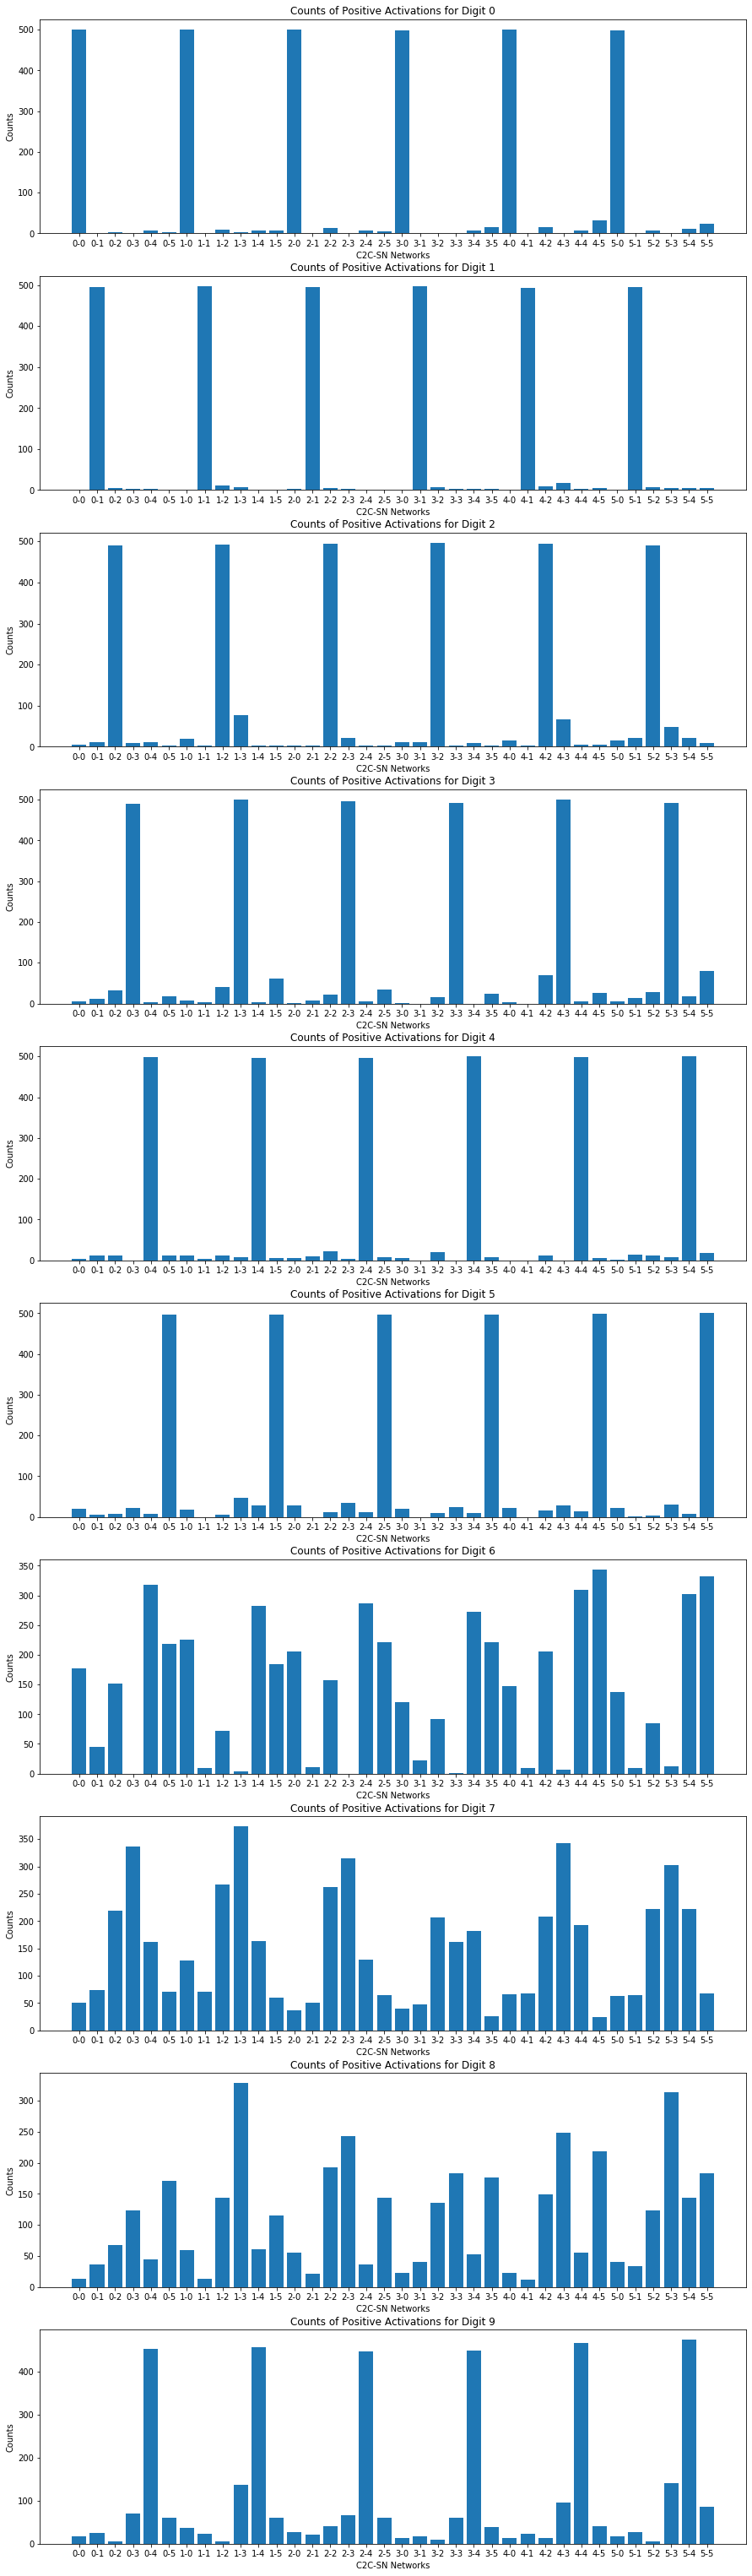

<Figure size 432x288 with 0 Axes>

In [22]:
#Plotting bar graphs for all possible compinations of digits and C2C-SNs
fig, axs = plt.subplots(10,1, figsize=(15,55))
c2c = [str(c1)+'-'+ str(c2) for c1 in range(6) for c2 in range(6)]
for i in range(counts.shape[0]):
  x = np.arange(36)
  axs[i].bar(x,counts[i])
  axs[i].set_xticks(x)
  axs[i].set_xticklabels(c2c,  minor=False)
  axs[i].set_title('Counts of Positive Activations for Digit ' + str(i))
  

for ax in axs.flat:
    ax.set(xlabel='C2C-SN Networks', ylabel='Counts')
plt.show()
plt.savefig('Counts.png')

for each example, we get a vector of length 36.

We observe that for seen cases, there are 6 positive activations and at a distance 6 from each other.

Any obervation which does not satisfy this criteria will be an outlier

In [23]:
# We classify an digit vector of length 36 as an outlier if it has more than 6 activations or if its consecutive activations 
# are not at distance 6 from each other
resultPredseen = np.load('resultPredseen.npy')
resultPredunseen = np.load('resultPredunseen.npy')


def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def outDetectbyVector(resultPred, threshold):
  resultPredbin = (resultPred>threshold)*1
  outPred = np.empty((resultPred.shape[0],resultPred.shape[2]))
  for i in range(resultPred.shape[0]):
    for j in range(resultPred.shape[2]):
      ind = np.where(resultPredbin[i,:,j] == 1)[0]
      if len(ind)==6:
        indDiff = [y-x for x,y in pairwise(ind)]
        indDiff = np.array(indDiff)
        if np.all(indDiff==6):
          outPred[i,j]=0
        else:
          outPred[i,j]=1
      else:
        outPred[i,j]=1
  return outPred

outPredseen = outDetectbyVector(resultPredseen, 0.5)
outPredunseen = outDetectbyVector(resultPredunseen, 0.5)



In [24]:
#Calculation of outlier detection accuracy for seen and unseen cases
def outAccuracy(outPred, seen):
  acc = []
  if seen:
    for i in range(outPred.shape[0]):
      acc.append((np.sum(outPred[i]==0)/len(outPred[i]))*100)
      
  else:
    for i in range(outPred.shape[0]):
      acc.append((np.sum(outPred[i]==1)/len(outPred[i]))*100)      
  return acc
acc_seen = outAccuracy(outPredseen,True)
acc_unseen = outAccuracy(outPredunseen,False)
tot_acc = acc_seen + acc_unseen
print(tot_acc)
np.save('OutlierAcc', tot_acc)

    


[86.0, 94.39999999999999, 63.2, 62.6, 78.0, 69.19999999999999, 96.0, 98.4, 93.4, 68.8]


Text(0, 0.5, 'Accuracy')

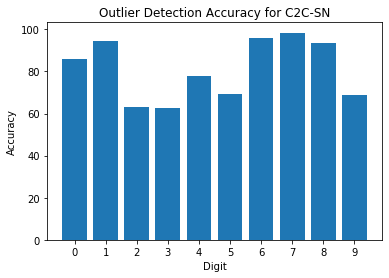

In [25]:
plt.bar(np.arange(10),tot_acc )
plt.title('Outlier Detection Accuracy for C2C-SN')
plt.xticks(np.arange(0,10,1))
plt.xlabel('Digit')
plt.ylabel('Accuracy')


In [26]:
#preparing data for finding the right number of clusters through elbow method.

X = np.concatenate(tuple([resultPredunseen[i] for i in range(resultPredunseen.shape[0])]), axis = 1)

outPred = np.concatenate(tuple([outPredunseen[i] for i in range(outPredunseen.shape[0])]))
X = X.T
X = X[outPred==1]
X.shape

(1783, 36)

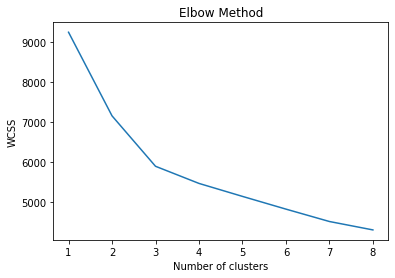

In [27]:
# implementing the elbow method to find the appropriate number of clusters

wcss = []
for i in range(1, 9):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 9), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


So there should be 3 clusters ideally. which means that two of the outliers have similar patterns

In [28]:
# Using Kmeans clustering for to create 4 clusters of resultant vectors
resultPred =  np.concatenate(tuple([resultPredunseen[i] for i in range(resultPredunseen.shape[0])]), axis = 1)
resultPred = resultPred.T
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(resultPred)
Clusters = np.empty((resultPredunseen.shape[0],resultPredunseen.shape[2]))
for i in range(resultPredunseen.shape[0]):
  Clusters[i] = kmeans.predict(resultPredunseen[i].T)


In [29]:
#Calculating the mode of the cluster
from scipy import stats
unseenDigits = [6,7,8,9]
for i in range(Clusters.shape[0]):
    temp = stats.mode(Clusters[i])
    print('Cluster mode of the digit '+ str(unseenDigits[i])+ ' is cluster '+ str(int(temp[0][0])+1)+ ' with count ' + str(temp[1][0]))


Cluster mode of the digit 6 is cluster 3 with count 260
Cluster mode of the digit 7 is cluster 2 with count 231
Cluster mode of the digit 8 is cluster 4 with count 227
Cluster mode of the digit 9 is cluster 3 with count 448


In [30]:
# calculating the mode of the digits
for i in range(4):
  clusterCount = [0,0,0,0]
  for j in range(4):
    clusterCount[j]+= np.sum((Clusters[i]==j)*1)
  print('The counts of 6, 7, 8, 9 in Cluster ' + str(i+1)+ ' are '+ str(clusterCount[0])+', '+str(clusterCount[1])+', '+str(clusterCount[2])+', '+str(clusterCount[3]) + ' respectively' )

The counts of 6, 7, 8, 9 in Cluster 1 are 235, 2, 260, 3 respectively
The counts of 6, 7, 8, 9 in Cluster 2 are 33, 231, 117, 119 respectively
The counts of 6, 7, 8, 9 in Cluster 3 are 131, 103, 39, 227 respectively
The counts of 6, 7, 8, 9 in Cluster 4 are 17, 1, 448, 34 respectively


the mode of cluster 1 is the digit 6

the mode of cluster 2 is the digit 7

the mode of cluster 3 is the digit 9

the mode of cluster 4 is the digit 8

In [32]:
# Clustering by Agglomerative method
resultPred =  np.concatenate(tuple([resultPredunseen[i] for i in range(resultPredunseen.shape[0])]), axis = 1)
resultPred = resultPred.T
Agglo = AgglomerativeClustering(n_clusters=4)
Agglo.fit(resultPred)
Clusters = np.empty((resultPredunseen.shape[0],resultPredunseen.shape[2]))
for i in range(resultPredunseen.shape[0]):
  Clusters[i] = kmeans.predict(resultPredunseen[i].T)

In [33]:
#Calculating the mode of the cluster
from scipy import stats
unseenDigits = [6,7,8,9]
for i in range(Clusters.shape[0]):
    temp = stats.mode(Clusters[i])
    print('Cluster mode of the digit '+ str(unseenDigits[i])+ ' is cluster '+ str(int(temp[0][0])+1)+ ' with count ' + str(temp[1][0]))


Cluster mode of the digit 6 is cluster 3 with count 260
Cluster mode of the digit 7 is cluster 2 with count 231
Cluster mode of the digit 8 is cluster 4 with count 227
Cluster mode of the digit 9 is cluster 3 with count 448


In [34]:

# calculating the mode of the digits
for i in range(4):
  clusterCount = [0,0,0,0]
  for j in range(4):
    clusterCount[j]+= np.sum((Clusters[i]==j)*1)
  print('The counts of 6, 7, 8, 9 in Cluster ' + str(i+1)+ ' are '+ str(clusterCount[0])+', '+str(clusterCount[1])+', '+str(clusterCount[2])+', '+str(clusterCount[3]) + ' respectively' )


The counts of 6, 7, 8, 9 in Cluster 1 are 235, 2, 260, 3 respectively
The counts of 6, 7, 8, 9 in Cluster 2 are 33, 231, 117, 119 respectively
The counts of 6, 7, 8, 9 in Cluster 3 are 131, 103, 39, 227 respectively
The counts of 6, 7, 8, 9 in Cluster 4 are 17, 1, 448, 34 respectively


In [35]:
# Creating a training set for KNN clustering
resultPred =  np.concatenate(tuple([resultPredseen[i] for i in range(resultPredseen.shape[0])]), axis = 1)
resultPred = resultPred.T
y = np.empty((resultPred.shape[0],))
for i in range(resultPredseen.shape[0]):
  y[i*500:i*500+500] = i+1



In [36]:
from sklearn.utils import shuffle
resultPred, y = shuffle(resultPred, y, random_state=0)

In [37]:
#Using Grid search Cross validation to find the appropriate number of neighbors for KNN classifer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(resultPred, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
# The best number of neighbors is 1,  useless absolutely useless
knn_gscv.best_params_

{'n_neighbors': 1}

In [39]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(resultPred,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [40]:
# predicting the clusters for each unseen class seperately
Clusters = np.empty((resultPredunseen.shape[0],resultPredunseen.shape[2]))
for i in range(resultPredunseen.shape[0]):
  Clusters[i] = knn.predict(resultPredunseen[i].T)

In [41]:
#Calculating the mode of the cluster
from scipy import stats
unseenDigits = [6,7,8,9]
for i in range(Clusters.shape[0]):
    temp = stats.mode(Clusters[i])
    print('Cluster mode of the digit '+ str(unseenDigits[i])+ ' is cluster '+ str(int(temp[0][0])+1)+ ' with count ' + str(temp[1][0]))


Cluster mode of the digit 6 is cluster 6 with count 235
Cluster mode of the digit 7 is cluster 5 with count 217
Cluster mode of the digit 8 is cluster 5 with count 209
Cluster mode of the digit 9 is cluster 6 with count 438


In [42]:

ClustProb = np.empty((resultPredunseen.shape[0],resultPredunseen.shape[2],resultPredseen.shape[0]))
for i in range(resultPredunseen.shape[0]):
  ClustProb[i] = knn.predict_proba(resultPredunseen[i].T)


In [43]:
meanProb = np.empty((4,6), dtype = 'int8')
for i in range(4):
  meanProb[i] = np.mean(ClustProb[i], axis = 0)*100
print(meanProb)

[[15  1  3  0 44 35]
 [ 4  7 19 43 21  2]
 [ 3  4 19 41  8 23]
 [ 1  2  0  5 85  4]]


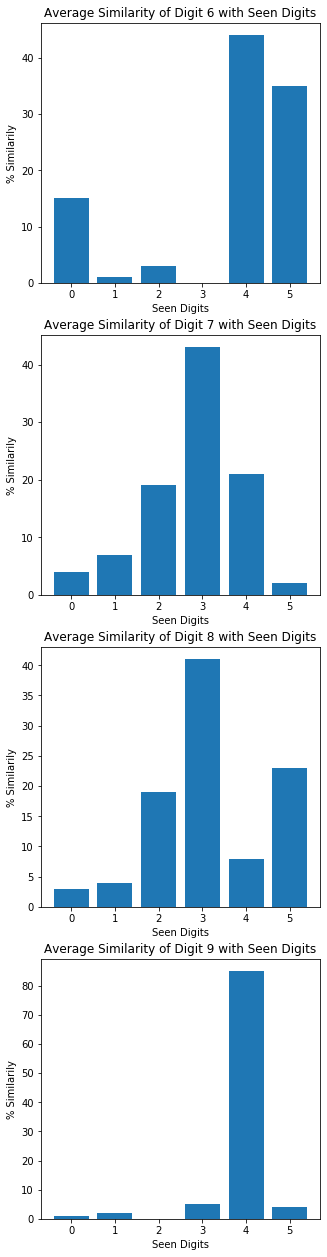

<Figure size 432x288 with 0 Axes>

In [44]:
#Plotting average similarity
fig, axs = plt.subplots(4,1, figsize=(5,22))
unseenDigit = [6,7,8,9]

for i in range(meanProb.shape[0]):
  x = np.arange(6)
  axs[i].bar(x,meanProb[i])
  axs[i].set_xticks(x)
  #axs[i].set_xticklabels(c2c,  minor=False)
  axs[i].set_title('Average Similarity of Digit ' + str(unseenDigit[i])+ ' with Seen Digits')

for ax in axs.flat:
    ax.set(xlabel='Seen Digits', ylabel='% Similarily')
plt.show()
plt.savefig('Average Similarity.png')